1-D Advection–Diffusion with a Continuous Point Release
==

This notebook simulates the solution to the unsteady 1-D advection diffusion with a continuous point
source at the origin.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
# Load code to make our simulation interactive in this notebook.
import ipywidgets as widgets

%matplotlib notebook

In [7]:
%%html
<style>
/* the 'stop' button is more like rewind, so change the icon */
i.fa-stop:before { content: "❚◀"; }
</style>

<IPython.core.display.Javascript object>


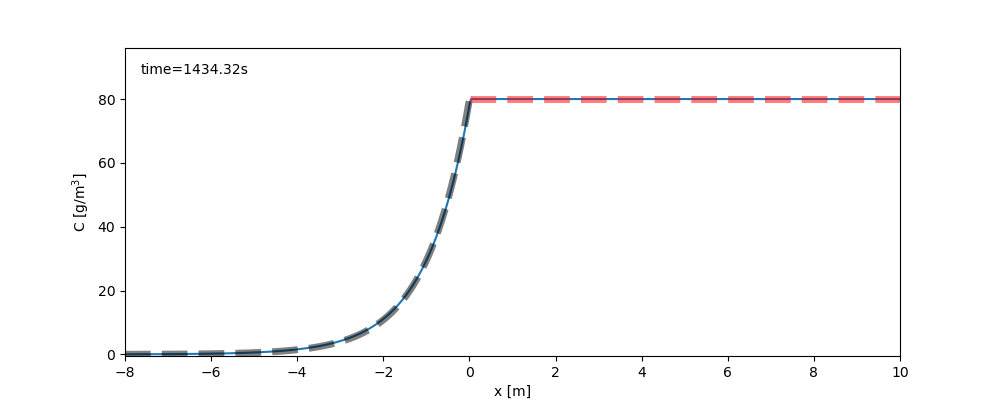

interactive(children=(Play(value=0, description='step', interval=20, max=1000000, show_repeat=False), FloatSli…

''

In [14]:
# Define the simulation parameters:
N=1001 # number of grid points in the simulation 
t=0.0 # time [s]
mdot=4.0 # source strength ~ [g/(m^2*s)]
Dnum=0.05 # initial diffusion coefficient, [m^2/s]
unum=0.05 # advection velocity [m/s]

x=np.linspace(-8,10,N) # discretized x coordinate
Cnum=np.zeros_like(x) # discretized concentration
dx=x[1]-x[0] # width of each finite volume cell

# Plot C vs x
fig,ax=plt.subplots(figsize=[10,4])
l=ax.plot(x,Cnum)[0] # keep a handle to the plot of concentration
def t_str():
    return f"time={t:7.2f}s"
t_label=ax.text(0.02,0.95,t_str(),transform=ax.transAxes,va='top')
ax.axis(xmin=x[0],xmax=x[-1],ymin=-0.5,ymax=1.2*mdot/unum)
ax.set_xlabel('x [m]')
ax.set_ylabel('C [g/m$^3$]')

# Simulation code:
# BEGIN 200B CONTENT:

# Implicit diffusion operator is mat_imp=I+D*dt/dx**2 * F
I=sparse.eye(N)
# F is the part of operator that scales with Dnum*dt/dx
d0=2*np.ones(N)
dp1=-np.ones(N)
dp1[1]*=2
dm1=-np.ones(N)
# dm1[-2:]*=2 # zero diffusive flux on downstream BC
dm1[-2:]=0
d0[-1]=0
F=sparse.spdiags( [dm1,d0,dp1], [-1,0,1], N, N).tocsr()

xedge=np.r_[x-dx/2,x[-1]+dx/2]

def plot_update(step,D,dt):
    global Dnum,Cnum,t
    Dnum=D
    
    if step==0: # reset to initial condition.
        Cnum=np.zeros_like(x)
        t=0.0
    else:
        t+=dt
        # Step forward in time
        # Advection:
        Cnum=np.interp(x,x+dt*unum,Cnum,left=0,right=0)
        # Source w/advection
        # add Csrc=mdot/u for the interval [0,u*dt]
        # integrate to get the cumulative distribution, then interpolate
        # and diff to get discrete distribution:
        # for x<0, cdf is 0.
        # over [0,u*dt] this should ramp up to mdot*dt 
        # Make an x coord array for the edge of the control volumes
        # The cumulative mass over [-inf,x_i] for each x_i in xedge,
        # for mass released over [0,dt]
        cmdf_x=np.interp( xedge, [0,unum*dt], [0,mdot*dt])
        mdf_x=np.diff(cmdf_x) # mass per CV
        Cnum[:]+=mdf_x/dx # concentratino per CV

        # Diffusion:
        mat_imp = I+Dnum*dt/dx**2*F
        Cnum=sparse.linalg.spsolve(mat_imp.tocsr(),Cnum)
    # Update the plot
    l.set_ydata(Cnum)
    t_label.set_text(t_str())

# END 200B content
    
widgets.interact(plot_update,
                 step=widgets.Play(value=0,
                                   min=0, max=1000000,
                                   step=1, interval=20,
                                   show_repeat=False),
                 D=widgets.FloatSlider(value=Dnum,min=0,max=1.0,step=0.001,
                                        description='D:',readout_format='.3f'),
                 dt=widgets.FloatSlider(value=0.4,min=0.01,max=1.0,step=0.01,
                                        description='timestep:', readout_format='.2f')
                )
;

In [15]:
# Overlay the analytical solution at steady state
C0=mdot/unum # steady state concentration for x>0
left=(x<=0) 
ax.plot(x[left],C0*np.exp(unum*x[left]/Dnum),'k--',lw=5,alpha=0.5)
ax.plot(x[~left],C0*np.ones_like(x[~left]),'r--',lw=5,alpha=0.5) ;

Reasoning:
---

The equation we're trying to solve is:
$$ \frac{\partial C}{\partial t} + u\frac{\partial C}{\partial x} = D \frac{\partial^2 C}{\partial x^2} + \dot{m}\delta(x)$$

The point source at the origin introduces a delta function $\dot{m} \delta(x)$ into the equation. Rather than wrestle with solving a PDE with a Dirac delta in it, we can use control volumes to understand that solution away from the source, and build solutions on either side of the source.

At steady state, for $x \neq 0$,

$$ u \frac{dC}{dx} = D \frac{d^2 C}{dx^2}$$   


Integrate both sides...

$$ uC = D\frac{dC}{dx} + A $$

drop this:
```
  Can't integrate again, as $C=C(x)$.
  One solution is that $C$ is constant, $dC/dx=0$, and we solve for $A$. This works for the +x side.
  One the -x side, we can assume that as $x\rightarrow-\infty$, $C\rightarrow 0$. If $C$ goes to zero, then 
  advective flux goes to zero and the    balancing  
  ```

The Peclet number tells us that as we get far from the source, advection dominates (taking $L~|x|$, and $Pe\equiv \frac{UL}{D}$. In our infinite domain, we can evaluate the behavior as $x$ goes to $\pm \infty$ by considering only advection. On the upstream side the concentration is $C_{-}=0$ (mass from the source is introduce downstream and flowing in the opposite direction).  On the downstream side, the advective flux is $J_A=uC$ and at steady state this must match the mass introduce by the source, $\dot{m}$, so the concentration far downstream is $C_{+}=\dot{m}/u$.

We now have suitable boundary conditions. What happens near the source?

Consider a control volume with the left side arbitrarily far out towards $-\infty$, and the right side at some $x_r<0$. This box has no flux in on the left, no internal sources, and its contained mass must be constant. The flux on the right side of the box must then be 0. Thus for any point x<0, net flux is zero, and the advective flux $J_A$ must be exactly balanced by diffusive flux $J_D$, or:

For $x<0$:
$$ uC=D \frac{dC}{dx}$$

We can solve this and find that $C(x)=C(x=0) e^{ux/D}$

HERE HERE HERE
If the right side of the CV is at $x>0$, then the box includes a source, but still no flux from the left. So the net flux out the right side must be equal the source.

$$uC -D \frac{dC}{dx} = \dot{m}/a$$

One solution is that $C$ is constant, the flux is entirely advective.

This is a first order ODE. So we need 1 BC. 

Could say that as $x\rightarrow \infty$, advection dominates, and if it's just a point source and advection then we can solve directly for the right BC. That feels a bit weak, but probably okay.

Can do a bit better than that:
$$C - \frac{\dot{m}}{au} = \frac{D}{u} \frac{dC}{dx} $$

$$ \int dx = \frac{D}{u} \int \frac{dC}{C- \dot{m}/au}$$

$$ x + B = \frac{D}{u} \ln [ C-\dot{m}/au ]$$

$$ C = B' e^\frac{ux}{D} + \dot{m}/au $$

We have a growing exponential and a constant. Knowing that as $x$ goes to $\infty$ $C$ is finite and nonzero, then $B'=0$